# Build Steam-OneFace dataset

The objective of this notebook is to gather a dataset:
-   of images downloaded from the **Steam** store or library,
-   with exactly **one face** per image (to decrease the dataset variability).

Images are also:
-   resized to 256x256 resolution,
-   de-duplicated, with a drastic approach (ALL of the matches are removed).

For more information, check:
-   my Github repository about [Steam-OneFace][steam-oneface-section]

This dataset could then be used for training with limited data, e.g. with:
-   https://github.com/woctezuma/steam-stylegan2-ada
-   https://github.com/mit-han-lab/data-efficient-gans
-   https://github.com/lucidrains/lightweight-gan

[steam-oneface-section]: <https://github.com/woctezuma/steam-filtered-image-data#steam-oneface-dataset>

## Install requirements

### Install

In [1]:
%pip install Google-Colab-Transfer imagededup face-alignment retinaface_pytorch > /dev/null

### Clone repositories with relevant text data

In [2]:
%cd /content/

# De-duplication
!git clone https://github.com/woctezuma/steam-filtered-image-data.git

# Face detection
!git clone https://github.com/woctezuma/steam-face-detection.git

/content
fatal: destination path 'steam-filtered-image-data' already exists and is not an empty directory.
fatal: destination path 'steam-face-detection' already exists and is not an empty directory.


## Boilerplate functions

### Utils

In [3]:
from pathlib import Path

def get_app_id(file_name):
  app_id = Path(file_name).name.strip('.jpg')
  return int(app_id)

def get_url(file_name):
  app_id = get_app_id(file_name)  
  url = 'https://cdn.cloudflare.steamstatic.com/steam/apps/{}/library_600x900.jpg'.format(app_id)
  return url

In [4]:
import glob

def list_file_names(image_dir):
  if not image_dir.endswith('/'):
    image_dir += '/'
  return glob.glob(image_dir + '*.jpg')

### For de-duplication

In [5]:
from imagededup.utils import plot_duplicates

def get_duplicates(encodings,
                   max_distance_threshold = 10):
  duplicates = encoder.find_duplicates(encoding_map=encodings,
                                      max_distance_threshold = max_distance_threshold)

  duplicates_all = [ f for f in duplicates if len(duplicates[f])>0 ]
  print('#duplicates = {}'.format(len(duplicates_all)))

  duplicates_to_remove = encoder.find_duplicates_to_remove(encoding_map=encodings,
                                                          max_distance_threshold = max_distance_threshold)
  print('#duplicates to remove = {}'.format(len(duplicates_to_remove)))

  return duplicates, duplicates_all, duplicates_to_remove

def visualize_duplicates(image_dir,
                         duplicates,
                         duplicates_all,
                         duplicates_to_remove,
                         threshold_for_display = 4):
  for fname in set(duplicates_all).difference(duplicates_to_remove):
    if len(duplicates[fname]) > threshold_for_display:
      plot_duplicates(image_dir=image_dir,
                      duplicate_map=duplicates,
                      filename=fname)
  return

### For face detection

#### Stats

In [6]:
from scipy import stats
import collections
import numpy as np
import matplotlib.pyplot as plt

def analyze_data(data):
  summary = stats.describe(data_for_faces)
  print(summary)

  bin_start = min(data_for_faces) - 0.5
  num_bins = max(data_for_faces) + 1

  _ = plt.hist(data_for_faces, bins=np.arange(num_bins)-0.5)
  plt.xticks(range(num_bins))
  plt.xlim([bin_start, num_bins])
  plt.title("Histogram of #detected_faces")
  plt.show()

  counter = collections.Counter(data_for_faces)
  most_common = counter.most_common()

  print('#images = {} ({:.0f}%) with #faces/image = {}'.format(
      most_common[0][1],      
      most_common[0][1]/sum(counter.values())*100,
      most_common[0][0],
      ))
  print('#other_images = {}'.format(
      sum(x[1] for x in most_common[1:])
  ))

  return

#### Detection

##### With Face_Alignment

In [7]:
import face_alignment

def load_fa_detector():
  detector = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D,
                                          face_detector='sfd')

  return detector

In [8]:
import face_alignment
from skimage import io

fa = load_fa_detector()

def apply_face_detection_with_fa(fname,
                                 refine_with_landmarks=False,
                                 use_BGR=True):

  try:
    input_img = io.imread(fname)
  except ValueError:
    input_img = None

  if input_img is None:
    df = []
  else:
    try:
      # Caveat: you need to go from RGB to BGR for the following function call:
      if use_BGR:
        df = fa.face_detector.detect_from_image(input_img[..., ::-1].copy())
      else:
        df = fa.face_detector.detect_from_image(input_img)
    except (ValueError, IndexError):
      df = []

  if len(df) == 0:
    p = []
  elif not refine_with_landmarks:
    p = df
  else:
    try:
      # This should always return the same number of faces, because we
      # provide the bounding boxes with the argument `detected_faces=df`:
      #
      # p = fa.get_landmarks_from_image(input_img, detected_faces=df)
      #
      # Otherwise, the following can return a different number of faces, because
      # it will interally use BGR for the detection of bounding boxes, and you
      # might have set `use_BGR=False` for the call to `detect_from_image()`.
      #
      p = fa.get_landmarks_from_image(input_img)
      #
      if len(df) != len(p):
        app_id = get_app_id(fname)
        print('[Warning] appID = {} ; #faces = {} (detect_from_image) ; #faces = {} (get_landmarks_from_image)'.format(app_id, len(df), len(p)))
    except IndexError:
      p = []

  num_faces = len(p)

  return num_faces

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-11f355bf06.pth.tar" to /root/.cache/torch/hub/checkpoints/2DFAN4-11f355bf06.pth.tar


##### With RetinaFace

In [20]:
from retinaface.pre_trained_models import get_model

def load_retinaface_detector(max_size = 840):
  # Caveat: max_size is a very important parameter (do not change if unsure)
  #
  # - cf. section 4.2 in the article, which suggests a value of 640:
  # "RetinaFace: Single-shot Multi-level Face Localisation in the Wild"
  #
  # - cf. config which suggests a value of 840:
  # https://github.com/ternaus/retinaface/issues/26

  detector = get_model("resnet50_2020-07-20",
                       max_size=max_size,
                       device='cuda')
  detector.eval()

  return detector

In [21]:
import time
import cv2
from skimage import io

def detect_retinafaces(image_rgb_or_path,
                       detector=None,
                       max_size = 840,
                       confidence_threshold = 0.08,
                       nms_threshold = 0.01,
                       verbose=False,
                       extra_verbose=False):
  # NB: confidence_threshold is an important parameter for hard cases.

  open_with_cv2 = False

  # Load the model: a detector to find the faces
  if detector is None:
    detector = load_retinaface_detector(max_size=max_size)

  if isinstance(image_rgb_or_path, str):
    try:
      if open_with_cv2:
        image_bgr = cv2.imread(image_rgb_or_path) # BGR
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # RGB
      else:
        image_rgb = io.imread(image_rgb_or_path) # RGB
    except ValueError:
      image_rgb = None
  else:
    image_rgb = image_rgb_or_path

  t = time.time()
  
  annotation = detector.predict_jsons(image_rgb,
                                      confidence_threshold=confidence_threshold,
                                      nms_threshold=nms_threshold)
  
  if verbose:
    print(f"Detection time: {time.time()- t:.3f} s")

  num_faces = len(annotation)

  if verbose:
    print("Number of faces detected: {}".format(num_faces))

  scores = [
            float('{:.3f}'.format(f['score']))
            for f in annotation
            ]

  if extra_verbose:
    print('Scores: {}'.format(scores))

  return annotation

In [22]:
retinaface_detector = load_retinaface_detector()

def apply_face_detection_with_retinaface(img_name,
                                         apply_fix=True):
  
  try:
    annotation = detect_retinafaces(img_name,
                                    detector=retinaface_detector)
  except (ValueError, AttributeError):
    annotation = []

  # **Caveat**: it can happen that `annotation` actually is:
  #   [{'bbox': [], 'score': -1, 'landmarks': []}]
  # in which case there is ZERO face, but the len(annotation) == 1
  # Hence the following filter:
  if apply_fix:
    filtered_annotation = [ df 
                            for df in annotation
                            if df['score'] > 0
                            ]
  else:
    filtered_annotation = annotation

  num_faces = len(filtered_annotation)

  return num_faces

/usr/local/lib/python3.6/dist-packages/torch/hub.py:483: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


##### Generic wrapper

In [12]:
def apply_face_detection(fname,
                         refine_with_landmarks=False,
                         use_BGR=True,
                         model_to_use='fa'):
  if model_to_use == 'fa':
    num_faces = apply_face_detection_with_fa(fname,
                                             refine_with_landmarks=refine_with_landmarks,
                                             use_BGR=use_BGR)
  else:
    num_faces = apply_face_detection_with_retinaface(fname)

  return num_faces

In [13]:
def process_image_batch(file_names,
                        refine_with_landmarks=False,
                        use_BGR=True,
                        model_to_use='fa'):
  app_id_dict = dict()
  for i, img_name in enumerate(file_names, start=1):
    if i % 500 == 0:
      print('[{}/{}] {} detected faces'.format(i, len(file_names), len(app_id_dict)))

    app_id = get_app_id(img_name)
    num_faces = apply_face_detection(img_name,
                                     refine_with_landmarks=refine_with_landmarks,
                                     use_BGR=use_BGR,
                                     model_to_use=model_to_use)

    if num_faces > 0:
      app_id_dict[app_id] = num_faces

  return app_id_dict

#### Disk utils

##### Generic functions

In [14]:
import json

def figure_filename(image_dir,
                    refine_with_landmarks=False,
                    use_BGR=True,
                    model_to_use='fa'):

  if refine_with_landmarks:
    prefixe = 'refined_'
  else:
    prefixe = ''

  base_fname = 'app_ids_with_faces_with_'

  if use_BGR is None:
    keyword = ''
  else:
    if use_BGR:
      keyword = '_BGR'
    else:
      keyword = '_RGB'

  if 'resized' in image_dir:
    suffixe = '_resized'
  else:
    suffixe = ''

  out_fname = '{}{}{}{}{}.json'.format(prefixe,
                                       base_fname,
                                       model_to_use,
                                       keyword,
                                       suffixe)
    
  return out_fname

def save_app_id_dict(app_id_dict,
                     image_dir,
                     refine_with_landmarks=False,
                     use_BGR=True,
                     model_to_use='fa'):

  out_fname = figure_filename(image_dir,
                              refine_with_landmarks=refine_with_landmarks,
                              use_BGR=use_BGR,
                              model_to_use=model_to_use)

  print('Saving {}'.format(out_fname))

  with open(out_fname, 'w') as f:
    json.dump(app_id_dict, f)

  return
  
def load_app_id_dict(image_dir,
                     refine_with_landmarks=False,
                     use_BGR=True,
                     model_to_use='fa'):

  out_fname = figure_filename(image_dir,
                              refine_with_landmarks=refine_with_landmarks,
                              use_BGR=use_BGR,
                              model_to_use=model_to_use)

  print('Loading {}'.format(out_fname))

  with open(out_fname, 'r') as f:
    app_id_dict = json.load(f)

  return app_id_dict

##### With Face_Alignment

In [15]:
def figure_filename_with_fa(image_dir,
                            refine_with_landmarks=False,
                            use_BGR=True):
  model_to_use='fa'

  return figure_filename(image_dir,
                         refine_with_landmarks=refine_with_landmarks,
                         use_BGR=use_BGR,
                         model_to_use=model_to_use)

def save_app_id_dict_with_fa(app_id_dict,
                             image_dir,
                             refine_with_landmarks=False,
                             use_BGR=True):
  model_to_use='fa'

  save_app_id_dict(app_id_dict,
                   image_dir,
                   refine_with_landmarks=refine_with_landmarks,
                   use_BGR=use_BGR,
                   model_to_use=model_to_use)

  return
  
def load_app_id_dict_with_fa(image_dir,
                             refine_with_landmarks=False,
                             use_BGR=True):
  model_to_use='fa'

  return load_app_id_dict(image_dir,
                         refine_with_landmarks=refine_with_landmarks,
                         use_BGR=use_BGR,
                         model_to_use=model_to_use)

##### With RetinaFace

In [16]:
def figure_filename_with_retinaface(image_dir):
  
  refine_with_landmarks=False,
  use_BGR=None
  model_to_use='retinaface'

  return figure_filename(image_dir,
                         refine_with_landmarks=refine_with_landmarks,
                         use_BGR=use_BGR,
                         model_to_use=model_to_use)

def save_app_id_dict_with_retinaface(app_id_dict,
                                     image_dir):
  
  refine_with_landmarks=False,
  use_BGR=None
  model_to_use='retinaface'

  save_app_id_dict(app_id_dict,
                   image_dir,
                   refine_with_landmarks=refine_with_landmarks,
                   use_BGR=use_BGR,
                   model_to_use=model_to_use)

  return
  
def load_app_id_dict_with_retinaface(image_dir):

  refine_with_landmarks=False,
  use_BGR=None
  model_to_use='retinaface'

  return load_app_id_dict(image_dir,
                         refine_with_landmarks=refine_with_landmarks,
                         use_BGR=use_BGR,
                         model_to_use=model_to_use)

### For combination

In [17]:
def get_combination(app_ids_strict,
                    duplicates_all,
                    app_id_dict,
                    max_num_faces = 1):
  filtered_app_ids = set(app_ids_strict)
  print('Strict: {}'.format(len(filtered_app_ids)))

  app_ids_to_keep = [int(i) for i in app_id_dict
                     if 0 < app_id_dict[i] <= max_num_faces]
  print('\nTo keep: {}'.format(len(app_ids_to_keep)))

  filtered_app_ids = filtered_app_ids.intersection(app_ids_to_keep)
  print('#appIDs = {}'.format(len(filtered_app_ids)))

  app_ids_to_remove = [int(i.strip('.jpg')) for i in duplicates_all]
  print('\nTo remove: {}'.format(len(app_ids_to_remove)))

  filtered_app_ids = filtered_app_ids.difference(app_ids_to_remove)
  print('#appIDs = {}'.format(len(filtered_app_ids)))

  return filtered_app_ids

## Download image data

### High-resolution images (300x450)

In [18]:
import glob
from pathlib import Path

archive_name = 'filtered_banners.tar.gz'
image_dir_hr = 'data/original_vertical_steam_banners/'

if not Path(archive_name).exists():
  !gdown --id 1etzhe-EYyT86DYK8QbEHoYoAeU1nqRWy
  !tar -xf {archive_name}

file_names = glob.glob(image_dir_hr + '*.jpg')
print('#images = {}'.format(len(file_names)))  

Downloading...
From: https://drive.google.com/uc?id=1etzhe-EYyT86DYK8QbEHoYoAeU1nqRWy
To: /content/filtered_banners.tar.gz
948MB [00:14, 65.0MB/s]
#images = 17492


### Low-resolution images (256x256)

In [19]:
import glob
from pathlib import Path

archive_name = 'resized_banners.tar.gz'
image_dir_lr = 'data/resized_vertical_steam_banners/'

if not Path(archive_name).exists():
  !gdown --id 1-7ukPUIZKWPyg-Lcj9b59Rr3rSJY8SuH
  !tar -xf {archive_name}

file_names = glob.glob(image_dir_lr + '*.jpg')
print('#images = {}'.format(len(file_names)))  

Downloading...
From: https://drive.google.com/uc?id=1-7ukPUIZKWPyg-Lcj9b59Rr3rSJY8SuH
To: /content/resized_banners.tar.gz
522MB [00:13, 39.4MB/s]
#images = 17492


## De-duplication

Reference: https://github.com/woctezuma/steam-filtered-image-data

### Pre-computed

-   only on high-resolution images,
-   with `max_distance_threshold = 0`

In [23]:
with open('steam-filtered-image-data/data/banners/duplicate_banners.txt', 'r') as f:
  duplicate_banners = [int(app_id.strip()) for app_id in f.readlines()]

with open('steam-filtered-image-data/data/logos/duplicate_logos.txt', 'r') as f:
  duplicate_logos = [int(app_id.strip()) for app_id in f.readlines()]

previously_known_duplicates = set(duplicate_banners).union(duplicate_logos)

with open('steam-filtered-image-data/data/merge/app_ids_strict.txt', 'r') as f:
  app_ids_strict = [int(app_id.strip()) for app_id in f.readlines()]

### From scratch

-   with `max_distance_threshold = 10`

In [24]:
from imagededup.methods import PHash

encoder = PHash()

#### High-resolution images (300x450)

In [25]:
encodings_hr = encoder.encode_images(image_dir=image_dir_hr)

2020-12-12 09:15:37,665: INFO Start: Calculating hashes...
 68%|██████▊   | 11901/17492 [00:42<00:21, 263.84it/s]2020-12-12 09:16:20,979: WARNING Invalid image file /content/data/original_vertical_steam_banners/1400030.jpg:
image file is truncated (32 bytes not processed)
100%|██████████| 17492/17492 [01:01<00:00, 282.40it/s]
2020-12-12 09:16:39,762: INFO End: Calculating hashes!


In [26]:
hr_duplicates, hr_duplicates_all, hr_duplicates_to_remove = get_duplicates(encodings_hr,
                                                                           max_distance_threshold = 10)

2020-12-12 09:16:39,775: INFO Start: Evaluating hamming distances for getting duplicates
2020-12-12 09:16:39,775: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 17491/17491 [00:01<00:00, 10570.24it/s]
2020-12-12 09:16:41,659: INFO End: Retrieving duplicates using Cython Brute force algorithm
2020-12-12 09:16:41,660: INFO End: Evaluating hamming distances for getting duplicates
2020-12-12 09:16:41,742: INFO Start: Evaluating hamming distances for getting duplicates
2020-12-12 09:16:41,743: INFO Start: Retrieving duplicates using Cython Brute force algorithm


#duplicates = 619


100%|██████████| 17491/17491 [00:01<00:00, 10760.08it/s]
2020-12-12 09:16:43,516: INFO End: Retrieving duplicates using Cython Brute force algorithm
2020-12-12 09:16:43,517: INFO End: Evaluating hamming distances for getting duplicates


#duplicates to remove = 308


/usr/local/lib/python3.6/dist-packages/imagededup/utils/plotter.py:66: UserWarning: tight_layout: falling back to Agg renderer
  gs.tight_layout(fig)


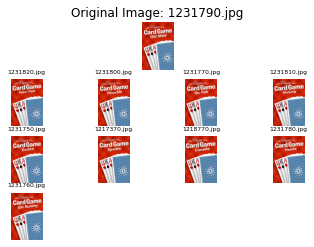

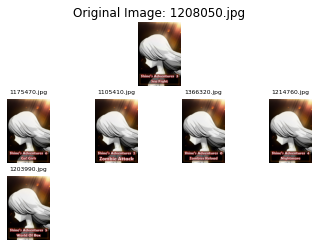

In [27]:
visualize_duplicates(image_dir_hr,
                     hr_duplicates,
                     hr_duplicates_all,
                     hr_duplicates_to_remove,
                     threshold_for_display = 4)

#### Low-resolution images (256x256)

In [28]:
encodings_lr = encoder.encode_images(image_dir=image_dir_lr)

2020-12-12 09:16:44,561: INFO Start: Calculating hashes...
100%|██████████| 17492/17492 [00:36<00:00, 475.69it/s]
2020-12-12 09:17:21,519: INFO End: Calculating hashes!


In [29]:
lr_duplicates, lr_duplicates_all, lr_duplicates_to_remove = get_duplicates(encodings_lr,
                                                                           max_distance_threshold = 10)

2020-12-12 09:17:21,534: INFO Start: Evaluating hamming distances for getting duplicates
2020-12-12 09:17:21,540: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 17492/17492 [00:01<00:00, 10186.51it/s]
2020-12-12 09:17:23,435: INFO End: Retrieving duplicates using Cython Brute force algorithm
2020-12-12 09:17:23,436: INFO End: Evaluating hamming distances for getting duplicates
2020-12-12 09:17:23,448: INFO Start: Evaluating hamming distances for getting duplicates
2020-12-12 09:17:23,449: INFO Start: Retrieving duplicates using Cython Brute force algorithm


#duplicates = 617


100%|██████████| 17492/17492 [00:01<00:00, 10835.45it/s]
2020-12-12 09:17:25,382: INFO End: Retrieving duplicates using Cython Brute force algorithm
2020-12-12 09:17:25,383: INFO End: Evaluating hamming distances for getting duplicates


#duplicates to remove = 314


/usr/local/lib/python3.6/dist-packages/imagededup/utils/plotter.py:66: UserWarning: tight_layout: falling back to Agg renderer
  gs.tight_layout(fig)


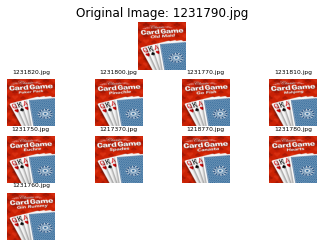

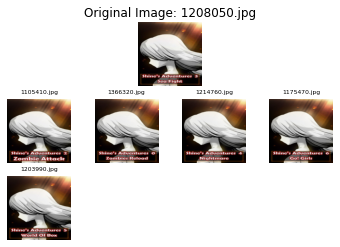

In [30]:
visualize_duplicates(image_dir_lr,
                     lr_duplicates,
                     lr_duplicates_all,
                     lr_duplicates_to_remove,
                     threshold_for_display = 4)

#### Merge

In [31]:
duplicates_all = set(hr_duplicates_all).union(lr_duplicates_all)
print('#duplicates = {}'.format(len(duplicates_all)))

#duplicates = 652


### Compare with pre-computed

In [32]:
allowed_app_ids = []
previously_missed_duplicates = []

for f_name in duplicates_all:
  app_id = get_app_id(f_name)

  # Duplicates missed at high-resolution (banners, logos), and detected here!
  if app_id not in previously_known_duplicates:
    previously_missed_duplicates.append(app_id)

  # Duplicates which I would have allowed, in the following "strict" setting:
  # - filter both banners AND logos at high-resolution,
  # - then remove ALL duplicates
  if app_id in app_ids_strict:
    allowed_app_ids.append(app_id)

print('#duplicates missed before = {}'.format(len(previously_missed_duplicates)))
print('#duplicates allowed in strict setting = {}'.format(len(allowed_app_ids)))

set_intersection = set(previously_missed_duplicates).intersection(allowed_app_ids)
print('cardinal of set intersection = {}'.format(len(set_intersection)))

#duplicates missed before = 529
#duplicates allowed in strict setting = 481
cardinal of set intersection = 481


/usr/local/lib/python3.6/dist-packages/imagededup/utils/plotter.py:66: UserWarning: tight_layout: falling back to Agg renderer
  gs.tight_layout(fig)


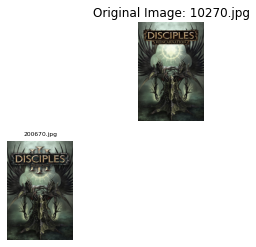

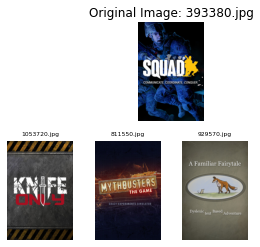

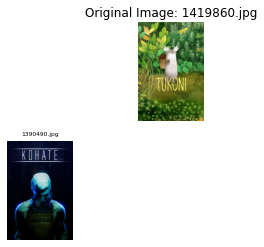

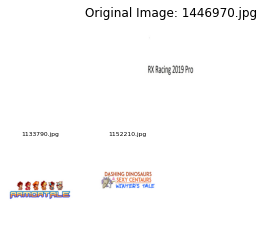

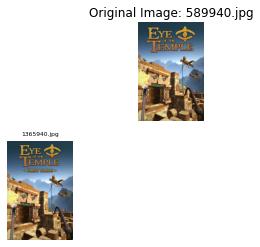

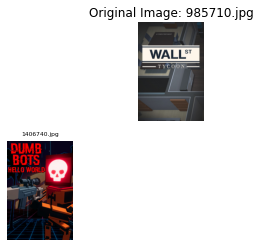

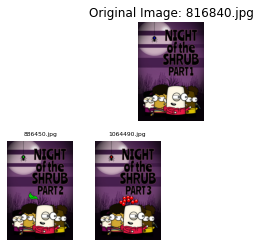

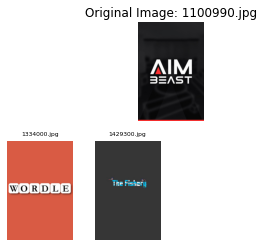

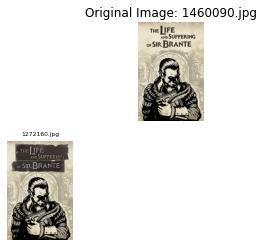

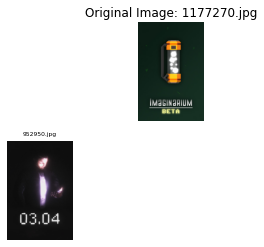

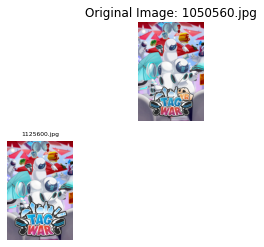

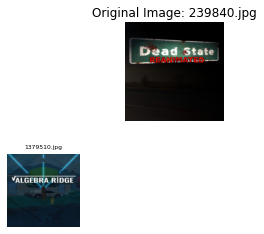

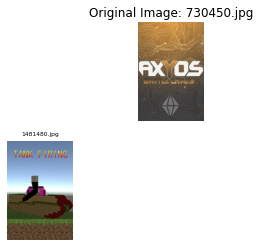

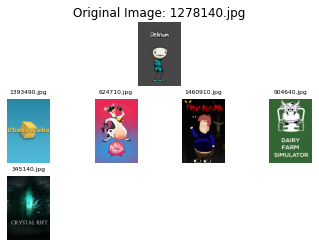

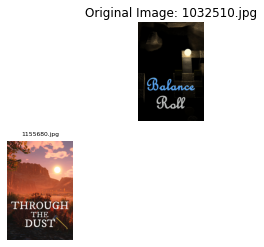

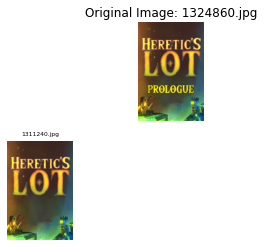

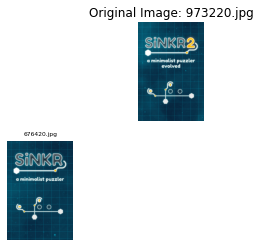

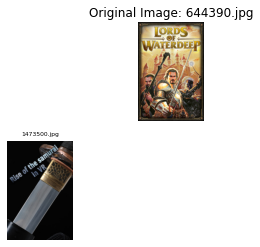

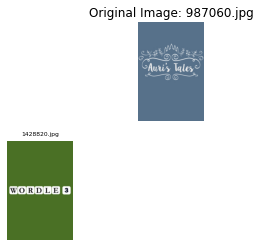

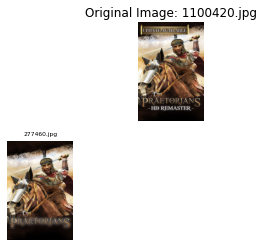

In [33]:
max_display = 20

for counter, app_id in enumerate(previously_missed_duplicates, start=1):
  if counter > max_display:
    break

  fname = str(app_id)+'.jpg'

  if fname in hr_duplicates_all:
    plot_duplicates(image_dir=image_dir_hr,
                    duplicate_map=hr_duplicates,
                    filename=fname)
  else:
    plot_duplicates(image_dir=image_dir_lr,
                    duplicate_map=lr_duplicates,
                    filename=fname)

## Face detection

Reference: https://github.com/woctezuma/steam-face-detection

### Pre-computed

-   on both high-resolution images and low-resolution images.

0 -> steam-face-detection/data/app_ids_with_faces_with_dlib.json
DescribeResult(nobs=2237, minmax=(1, 13), mean=1.3696915511846222, variance=0.7134459244947753, skewness=3.799651311101779, kurtosis=25.14427937402034)


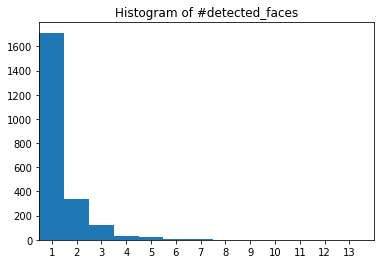

#images = 1714 (77%) with #faces/image = 1
#other_images = 523
----------------------------------------------------------------------
1 -> steam-face-detection/data/app_ids_with_faces_with_dlib_resized.json
DescribeResult(nobs=563, minmax=(1, 4), mean=1.1314387211367674, variance=0.16418778404960716, skewness=3.542570476579001, kurtosis=14.36994905036585)


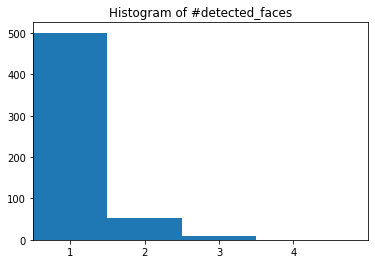

#images = 501 (89%) with #faces/image = 1
#other_images = 62
----------------------------------------------------------------------
2 -> steam-face-detection/data/app_ids_with_faces_with_fa_BGR.json
DescribeResult(nobs=5197, minmax=(1, 36), mean=1.7250336732730422, variance=2.073917074500996, skewness=5.619570341830829, kurtosis=79.88756242829281)


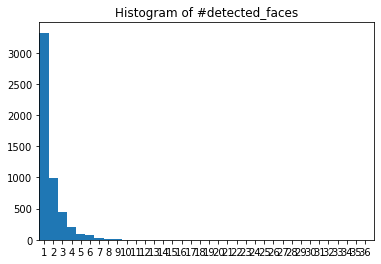

#images = 3324 (64%) with #faces/image = 1
#other_images = 1873
----------------------------------------------------------------------
3 -> steam-face-detection/data/app_ids_with_faces_with_fa_BGR_resized.json
DescribeResult(nobs=3971, minmax=(1, 19), mean=1.5295895240493578, variance=1.2874743654720906, skewness=4.27299333780459, kurtosis=34.09415998527822)


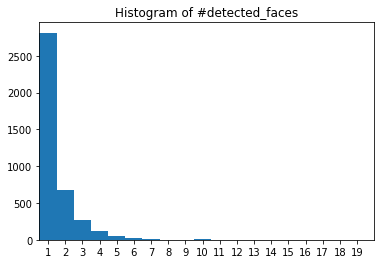

#images = 2812 (71%) with #faces/image = 1
#other_images = 1159
----------------------------------------------------------------------
4 -> steam-face-detection/data/app_ids_with_faces_with_fa_RGB.json
DescribeResult(nobs=4393, minmax=(1, 41), mean=1.5258365581607103, variance=1.5339976208216666, skewness=10.473393549530492, kurtosis=261.0959156716164)


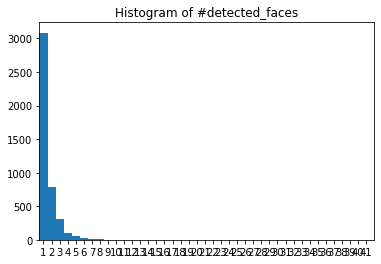

#images = 3085 (70%) with #faces/image = 1
#other_images = 1308
----------------------------------------------------------------------
5 -> steam-face-detection/data/app_ids_with_faces_with_fa_RGB_resized.json
DescribeResult(nobs=2734, minmax=(1, 15), mean=1.343818580833943, variance=0.7137982195448568, skewness=4.525053098603649, kurtosis=37.38370020666418)


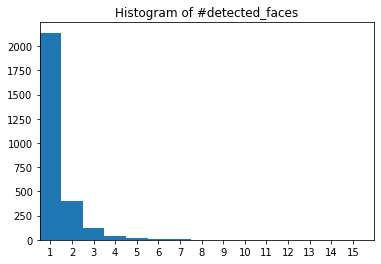

#images = 2139 (78%) with #faces/image = 1
#other_images = 595
----------------------------------------------------------------------
6 -> steam-face-detection/data/app_ids_with_faces_with_retinaface.json
DescribeResult(nobs=8717, minmax=(1, 241), mean=2.427784788344614, variance=17.09657991329313, skewness=26.660758712869722, kurtosis=1332.6428645998617)


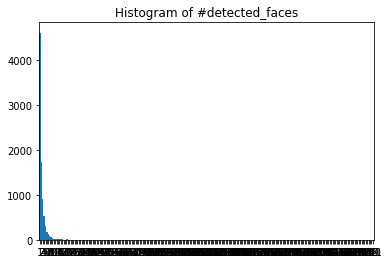

#images = 4607 (53%) with #faces/image = 1
#other_images = 4110
----------------------------------------------------------------------
7 -> steam-face-detection/data/app_ids_with_faces_with_retinaface_resized.json
DescribeResult(nobs=8507, minmax=(1, 152), mean=2.159985893969672, variance=9.428316388232691, skewness=20.97163094990213, kurtosis=811.2288028562652)


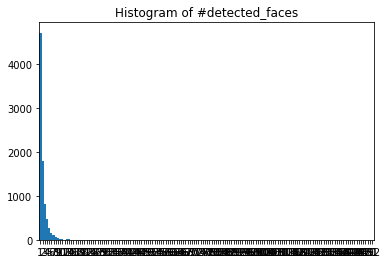

#images = 4706 (55%) with #faces/image = 1
#other_images = 3801
----------------------------------------------------------------------


In [34]:
import glob
import json

fnames = glob.glob('steam-face-detection/data/*.json')
fnames.sort()
for i, fname in enumerate(fnames):
  print('{} -> {}'.format(i, fname))
  
  with open(fname, 'r') as f:
    app_id_dict = json.load(f)

  data_for_faces = [ i for i in app_id_dict.values() ]

  analyze_data(data_for_faces)
  print('-'*70)

### From scratch

In [35]:
# model_to_use = 'fa'
model_to_use = 'retinaface'

In [36]:
# Recommended value: False (to avoid running unnecessary computations)
refine_with_landmarks = False

# Recommended value: True (to copy face_alignment's internal process)
use_BGR = True

#### High-resolution images (300x450)

In [37]:
from collections import Counter

image_dir = 'data/original_vertical_steam_banners'

print('Directory: {}'.format(image_dir))
file_names = list_file_names(image_dir=image_dir)

app_id_dict = process_image_batch(file_names,
                                  refine_with_landmarks=refine_with_landmarks,
                                  use_BGR=use_BGR,
                                  model_to_use=model_to_use)
save_app_id_dict(app_id_dict,
                 image_dir,
                 refine_with_landmarks=refine_with_landmarks,
                 use_BGR=use_BGR,
                 model_to_use=model_to_use)

Directory: data/original_vertical_steam_banners
[500/17492] 261 detected faces
[1000/17492] 509 detected faces
[1500/17492] 758 detected faces
[2000/17492] 987 detected faces
[2500/17492] 1263 detected faces
[3000/17492] 1503 detected faces
[3500/17492] 1757 detected faces
[4000/17492] 2015 detected faces
[4500/17492] 2294 detected faces
[5000/17492] 2549 detected faces
[5500/17492] 2789 detected faces
[6000/17492] 3036 detected faces
[6500/17492] 3301 detected faces
[7000/17492] 3546 detected faces
[7500/17492] 3812 detected faces
[8000/17492] 4040 detected faces
[8500/17492] 4274 detected faces
[9000/17492] 4525 detected faces
[9500/17492] 4752 detected faces
[10000/17492] 5003 detected faces
[10500/17492] 5238 detected faces
[11000/17492] 5471 detected faces
[11500/17492] 5722 detected faces
[12000/17492] 5957 detected faces
[12500/17492] 6190 detected faces
[13000/17492] 6434 detected faces
[13500/17492] 6690 detected faces
[14000/17492] 6945 detected faces
[14500/17492] 7233 detec

Loading app_ids_with_faces_with_retinaface_BGR.json
Counter({1: 4607, 2: 1735, 3: 900, 4: 526, 5: 300, 6: 182, 7: 131, 8: 81, 9: 58, 10: 43, 11: 24, 12: 24, 13: 14, 15: 11, 17: 9, 14: 9, 20: 8, 16: 7, 21: 7, 26: 6, 19: 6, 25: 3, 22: 3, 18: 3, 30: 2, 46: 2, 47: 2, 52: 1, 35: 1, 37: 1, 38: 1, 89: 1, 63: 1, 60: 1, 241: 1, 83: 1, 32: 1, 24: 1, 27: 1, 41: 1, 43: 1})
DescribeResult(nobs=8717, minmax=(1, 241), mean=2.427784788344614, variance=17.09657991329313, skewness=26.66075871286971, kurtosis=1332.642864599862)


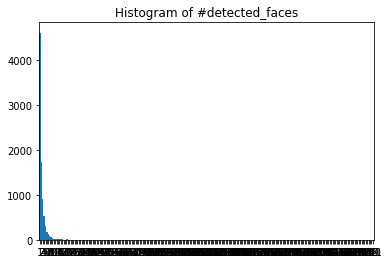

#images = 4607 (53%) with #faces/image = 1
#other_images = 4110


In [38]:
image_dir = 'data/original_vertical_steam_banners'

app_id_dict_hr = load_app_id_dict(image_dir,
                                  refine_with_landmarks=refine_with_landmarks,
                                  use_BGR=use_BGR,
                                  model_to_use=model_to_use)

counter = Counter(app_id_dict_hr.values())
print(counter)

data_for_faces = [ i for i in app_id_dict_hr.values() ]
analyze_data(data_for_faces)

#### Low-resolution images (256x256)

In [39]:
from collections import Counter

image_dir = 'data/resized_vertical_steam_banners'

print('Directory: {}'.format(image_dir))
file_names = list_file_names(image_dir=image_dir)

app_id_dict = process_image_batch(file_names,
                                  refine_with_landmarks=refine_with_landmarks,
                                  use_BGR=use_BGR,
                                  model_to_use=model_to_use)
save_app_id_dict(app_id_dict,
                 image_dir,
                 refine_with_landmarks=refine_with_landmarks,
                 use_BGR=use_BGR,
                 model_to_use=model_to_use)

Directory: data/resized_vertical_steam_banners
[500/17492] 264 detected faces
[1000/17492] 524 detected faces
[1500/17492] 764 detected faces
[2000/17492] 985 detected faces
[2500/17492] 1251 detected faces
[3000/17492] 1498 detected faces
[3500/17492] 1749 detected faces
[4000/17492] 2010 detected faces
[4500/17492] 2270 detected faces
[5000/17492] 2512 detected faces
[5500/17492] 2746 detected faces
[6000/17492] 2986 detected faces
[6500/17492] 3244 detected faces
[7000/17492] 3481 detected faces
[7500/17492] 3743 detected faces
[8000/17492] 3968 detected faces
[8500/17492] 4215 detected faces
[9000/17492] 4458 detected faces
[9500/17492] 4679 detected faces
[10000/17492] 4909 detected faces
[10500/17492] 5137 detected faces
[11000/17492] 5360 detected faces
[11500/17492] 5604 detected faces
[12000/17492] 5832 detected faces
[12500/17492] 6072 detected faces
[13000/17492] 6304 detected faces
[13500/17492] 6556 detected faces
[14000/17492] 6809 detected faces
[14500/17492] 7062 detect

Loading app_ids_with_faces_with_retinaface_BGR_resized.json
Counter({1: 4706, 2: 1782, 3: 804, 4: 468, 5: 279, 6: 160, 7: 100, 8: 61, 9: 38, 10: 26, 14: 15, 11: 14, 13: 11, 17: 6, 12: 6, 16: 5, 15: 4, 21: 3, 18: 3, 20: 3, 19: 2, 27: 1, 39: 1, 40: 1, 82: 1, 84: 1, 42: 1, 45: 1, 50: 1, 152: 1, 55: 1, 24: 1})
DescribeResult(nobs=8507, minmax=(1, 152), mean=2.159985893969672, variance=9.428316388232693, skewness=20.97163094990212, kurtosis=811.2288028562648)


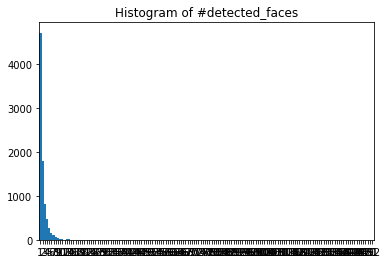

#images = 4706 (55%) with #faces/image = 1
#other_images = 3801


In [40]:
image_dir = 'data/resized_vertical_steam_banners'

app_id_dict_lr = load_app_id_dict(image_dir,
                                  refine_with_landmarks=refine_with_landmarks,
                                  use_BGR=use_BGR,
                                  model_to_use=model_to_use)

counter = Counter(app_id_dict_lr.values())
print(counter)

data_for_faces = [ i for i in app_id_dict_lr.values() ]
analyze_data(data_for_faces)

#### Merge

Counter({1: 2713, 2: 697, 3: 286, 4: 136, 5: 72, 6: 25, 7: 19, 8: 12, 9: 6, 17: 2, 10: 2, 14: 1, 20: 1, 12: 1, 18: 1})
DescribeResult(nobs=3974, minmax=(1, 20), mean=1.6155007549068947, variance=1.6628454954688485, skewness=4.403158979329145, kurtosis=35.39346785125749)


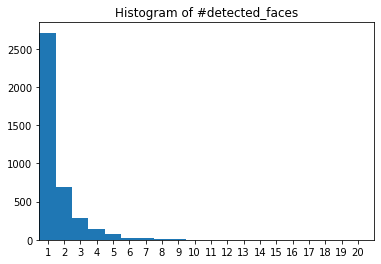

#images = 2713 (68%) with #faces/image = 1
#other_images = 1261


In [42]:
common_app_ids = set(app_id_dict_hr).intersection(app_id_dict_lr)

app_id_dict = dict()
for app_id in common_app_ids:
  m = app_id_dict_hr[app_id]
  n = app_id_dict_lr[app_id]
  if m == n:
    app_id_dict[app_id] = m

counter = Counter(app_id_dict.values())
print(counter)

data_for_faces = [ i for i in app_id_dict.values() ]
analyze_data(data_for_faces)    

Done.

## Combination

### Pre-computed

#### Display stats

In [43]:
import glob
import json

for i, fname in enumerate(fnames):
  print('{} -> {}'.format(i, fname))

  with open(fname, 'r') as f:
    d = json.load(f)

  filtered_app_ids = get_combination(app_ids_strict,
                                     duplicates_all,
                                     app_id_dict=d,
                                     max_num_faces = 1)
  print('-'*70)

0 -> steam-face-detection/data/app_ids_with_faces_with_dlib.json
Strict: 16231

To keep: 1714
#appIDs = 1610

To remove: 652
#appIDs = 1569
----------------------------------------------------------------------
1 -> steam-face-detection/data/app_ids_with_faces_with_dlib_resized.json
Strict: 16231

To keep: 501
#appIDs = 462

To remove: 652
#appIDs = 448
----------------------------------------------------------------------
2 -> steam-face-detection/data/app_ids_with_faces_with_fa_BGR.json
Strict: 16231

To keep: 3324
#appIDs = 3127

To remove: 652
#appIDs = 3054
----------------------------------------------------------------------
3 -> steam-face-detection/data/app_ids_with_faces_with_fa_BGR_resized.json
Strict: 16231

To keep: 2812
#appIDs = 2637

To remove: 652
#appIDs = 2572
----------------------------------------------------------------------
4 -> steam-face-detection/data/app_ids_with_faces_with_fa_RGB.json
Strict: 16231

To keep: 3085
#appIDs = 2908

To remove: 652
#appIDs = 28

#### Combine

6 -> steam-face-detection/data/app_ids_with_faces_with_retinaface.json
7 -> steam-face-detection/data/app_ids_with_faces_with_retinaface_resized.json
DescribeResult(nobs=7103, minmax=(1, 241), mean=2.9322821343094465, variance=21.19352685252082, skewness=23.651289332618312, kurtosis=1055.8214628816995)


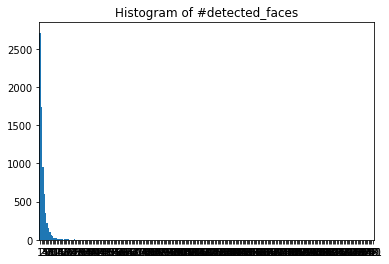

#images = 2713 (38%) with #faces/image = 1
#other_images = 4390
Strict: 16231

To keep: 2713
#appIDs = 2527

To remove: 652
#appIDs = 2472


In [44]:
import glob
import json

# selected_indices = range(len(fnames))
# selected_indices = [2,3,4,5]
# selected_indices = [2,3]
# selected_indices = [4,5]
selected_indices = [6,7]

d_combined = None

for i, fname in enumerate(fnames):
  if i not in selected_indices:
    continue

  print('{} -> {}'.format(i, fname))

  with open(fname, 'r') as f:
    d = json.load(f)

  if d_combined is None:
    d_combined = dict(d)
  else:
    temp = list(d_combined.keys())
    for i in temp:
      if i in d:
        d_combined[i] = max(d_combined[i], d[i])
      else:
        d_combined.pop(i)        

data_for_faces = [ i for i in d_combined.values() ]

analyze_data(data_for_faces)

filtered_app_ids = get_combination(app_ids_strict,
                                    duplicates_all,
                                    app_id_dict=d_combined,
                                    max_num_faces = 1)

### From scratch

In [45]:
filtered_app_ids = get_combination(app_ids_strict,
                                   duplicates_all,
                                   app_id_dict=app_id_dict,
                                   max_num_faces = 1)

Strict: 16231

To keep: 2713
#appIDs = 2527

To remove: 652
#appIDs = 2472


### Export

In [46]:
from pathlib import Path

def get_input_folder(resolution='hr'):
  if resolution == 'hr':
    input_folder = image_dir_hr
  else:
    input_folder = image_dir_lr

  return input_folder

def get_output_folder(resolution='hr'):
  output_folder = 'steam-oneface-{}/'.format(resolution)
  Path(output_folder).mkdir(exist_ok=True)

  return output_folder

def get_output_archive(resolution='hr',
                       model_to_use='fa'):
  if model_to_use == 'fa':
    suffixe = ''
  else:
    suffixe = '_with_{}'.format(model_to_use)

  output_folder = get_output_folder(resolution)
  archive_name = output_folder.strip('/') + suffixe + '.tar.gz'

  return archive_name

In [47]:
import shutil

for resolution in ['hr', 'lr']:
  input_folder = get_input_folder(resolution)
  output_folder = get_output_folder(resolution)

  for app_id in filtered_app_ids:
    fname = str(app_id) + '.jpg'
    shutil.copyfile(input_folder + fname, 
                    output_folder + fname)

In [48]:
for resolution in ['hr', 'lr']:
  output_folder = get_output_folder(resolution)
  archive_name = get_output_archive(resolution,
                                    model_to_use=model_to_use)
  
  !du -sh {output_folder}
  !tar -cf {archive_name} {output_folder}
  !du -sh {archive_name}

137M	steam-oneface-hr/
133M	steam-oneface-hr_with_retinaface.tar.gz
78M	steam-oneface-lr/
75M	steam-oneface-lr_with_retinaface.tar.gz


In [49]:
import colab_transfer

gd = colab_transfer.get_path_to_home_of_google_drive()
lm = colab_transfer.get_path_to_home_of_local_machine()

colab_transfer.mount_google_drive()

Mounted at /content/drive/


In [51]:
app_ids_for_hr = [get_app_id(fname) for fname in list_file_names('steam-oneface-hr/')]
app_ids_for_lr = [get_app_id(fname) for fname in list_file_names('steam-oneface-lr/')]
assert(app_ids_for_hr == app_ids_for_lr)

output_log_name = 'app_ids_with_{}.txt'.format(model_to_use)

with open(output_log_name, 'w') as f:
  for i in sorted(app_ids_for_hr, key=int):
    f.write('{}\n'.format(i))

colab_transfer.copy_file(file_name=output_log_name,
                          source = lm,
                          destination = gd)

Copying /content/app_ids_with_retinaface.txt to /content/drive/My Drive/app_ids_with_retinaface.txt


In [52]:
for resolution in ['hr', 'lr']:
  output_folder = get_output_folder(resolution)
  archive_name = get_output_archive(resolution,
                                    model_to_use=model_to_use)

  colab_transfer.copy_file(file_name=archive_name,
                           source = lm,
                           destination = gd)

Copying /content/steam-oneface-hr_with_retinaface.tar.gz to /content/drive/My Drive/steam-oneface-hr_with_retinaface.tar.gz
Copying /content/steam-oneface-lr_with_retinaface.tar.gz to /content/drive/My Drive/steam-oneface-lr_with_retinaface.tar.gz


Done.